In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy import constants
import function as f
from scipy.signal import find_peaks
from NewCalibration import Calib_position
from NewCalibration import Calib_energy
from NewCalibration import Calib_channel


work_dir = os.getcwd()

In [3]:
filename = '20240823_cross_section_data.txt'
filepath = os.path.join(work_dir, filename)

my_df = pd.read_csv(filepath, sep=' ', header=0)

In [4]:
# extracting only data where macropulse=0 and energy !=0
index = my_df['macropulse'].loc[my_df['macropulse']==1].index
new_df = my_df.drop(index)

index_en = new_df['energy'].loc[new_df['energy']==0].index
df = new_df.drop(index_en)

Text(0.8, 0.6, 'Lu-156')

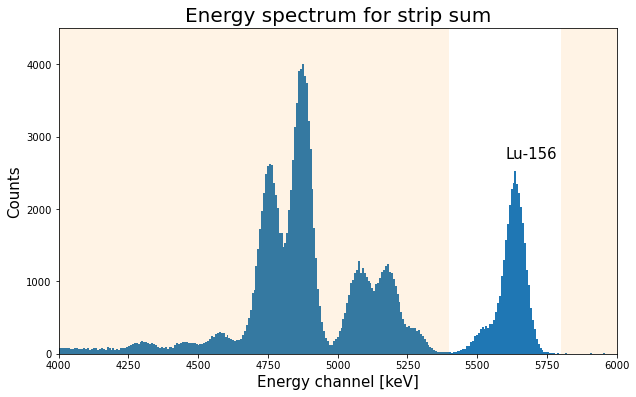

In [6]:
# plotting the energy spectrum
plt.figure(figsize=(10,6))
ax=plt.gca()
height, xedges, yedges = plt.hist(df['energy'], bins=5000)
plt.xlim([4000,6000])
plt.title('Energy spectrum for strip sum', fontsize=20)
plt.xlabel('Energy channel [keV]', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.axhspan(0, np.max(height)+500, 0, 0.7, facecolor='darkorange', alpha=0.1)
plt.axhspan(0, np.max(height)+500, 0.9, 1, facecolor='darkorange', alpha=0.1)
plt.ylim([0, np.max(height)+500])
plt.text(0.8, 0.6, 'Lu-156', transform=ax.transAxes, fontsize=15)


pp[0] = 0.26792219549532104 +/- 0.41528726638259156
pp[1] = 19.41374905901052 +/- 0.6749987002131644
pp[2] = 5530.575258262392 +/- 2.964374255665504
pp[3] = 42.30191571445975 +/- 2.837915682877395
pp[4] = 138.58532807051506 +/- 0.7739069219527188
pp[5] = 5637.244636237673 +/- 0.3678626480468603
pp[6] = 34.59070067605264 +/- 0.31615940105581974
counts at detector = 35739.00 +/- 0.40


Text(0.05, 0.9, 'Counts = 35739')

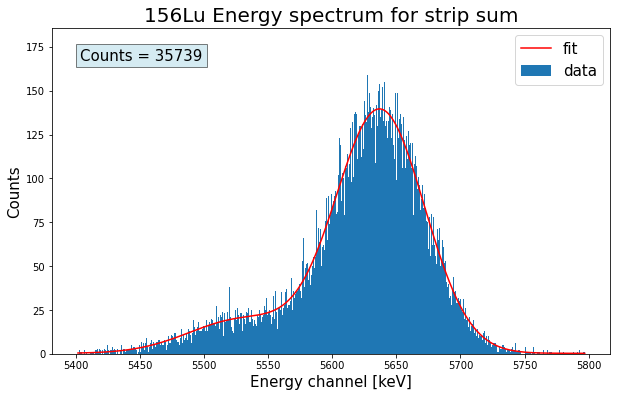

In [ ]:
# I want to select only the number of counts in that energy window

cond1 = df['energy'] >= 5400
cond2 = df['energy'] <= 5800
window = np.logical_and(cond1 , cond2)

lu_df = df[window]

# plotting the energy spectrum for 156Lu
plt.figure(figsize=(10,6))
ax=plt.gca()
height, xedges, yedges = plt.hist(lu_df['energy'], bins=1000, label='data')
#plt.xlim([4000,6000])
plt.title('156Lu Energy spectrum for strip sum', fontsize=20)
plt.xlabel('Energy channel [keV]', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.ylim([0, np.max(height)+20])


xcenters = (xedges[:-1]+xedges[1:])/2 # getting the centers of the bins

bin_width = xedges[1]-xedges[0]
err = np.ones(len(xcenters))*bin_width # bin width as error for fit

popt, pcov = optimize.curve_fit(f.multi_gauss2, xcenters, height, sigma=err, p0=[0, 25, 5500, 50, 150, 5625, 50]) # fit

for ii in range(len(popt)):
    print("pp[%d] =" % ii, popt[ii], "+/-", pcov[ii,ii]**0.5) # printing best fit parameters


plt.plot(xcenters, f.multi_gauss2(xcenters, *popt),'r-', label='fit') # plotting fit result
plt.legend(fontsize=15)

# getting the number of counts
gauss1_mean = popt[2]
gauss1_sigma = popt[3]
gauss2_mean = popt[5]
gauss2_sigma = popt[6]

low_bound = lu_df['energy'] >= gauss1_mean - 3*gauss1_sigma  # selecting the central value +/- FWHM/2
up_bound = lu_df['energy'] <= gauss2_mean + 3*gauss2_sigma
energy_range = np.logical_and(low_bound, up_bound)
final_df = lu_df[energy_range]

counts = len(final_df['energy']) # counts in the area of interest
err_counts = bin_width # bin width as error on the selected area
print('counts at detector = %.2f +/- %.2f' % (counts, err_counts))
plt.text(0.05, 0.9, 'Counts = 35739', transform=ax.transAxes, fontsize=15, bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(0.07, 0.2, 'T_{1/2}=', transform=ax.transAxes, fontsize=15, bbox=dict(facecolor='lightblue', alpha=0.5), usetex=True)

In [17]:
# pause correction factor
rep_rate = 5 #[Hz]
pulse_length = 3 * 10**(-3) #[s]
err_pulse_length = 0.1 * pulse_length # 10% error on pulse length
pcf = 1 / (1 - rep_rate * pulse_length)
err_pcf = rep_rate / (1 - rep_rate * pulse_length)**2 * err_pulse_length
print('pcf = %.3f +/- %.3f' % (pcf,err_pcf))

# separator efficiency
sep_eff = 0.30 # from literature
err_sep_eff = 0.05 * sep_eff # 5% error on sep_sep_efficiency

# detector efficiency
det_eff = 0.55
err_det_eff = 0.05*det_eff

# counts at target
counts_at = counts * pcf / sep_eff / det_eff
err_counts_at = np.sqrt((err_counts * pcf / sep_eff)**2 + (err_pcf * counts / sep_eff)**2 + (err_sep_eff * counts * pcf / sep_eff**2)**2 + (err_det_eff * counts * pcf / det_eff**2)**2)
print('counts at target = %.3f +/- %.3f' % (counts_at, err_counts_at))

# atoms / cm^2 at target
adt = 400 * 10**(-6) #[g/cm^2]
err_adt = 0.1 * adt # 10% error on area density of target
mass = 106.9051 #[g] for 107Ag
target = adt * constants.Avogadro / mass
err_target = err_adt * constants.Avogadro / mass
print('target = %.3e +/- %.3e' % (target, err_target))

# atoms for beam
current = 16 * 10**(-6) #[A]
err_current = 0.05 * current # 5% error on current
charge_state = 14
tot_meas_time = 210 # [s]
err_tot_meas_time = 10 # 10 seconds error con measurement time 
beam = current / constants.e / charge_state * tot_meas_time * rep_rate * pulse_length
err_beam = np.sqrt((err_current * beam / current)**2 + (err_tot_meas_time * beam / tot_meas_time)**2 + (err_pulse_length * beam / pulse_length)**2)
print('beam = %.3e +/- %.3e' % (beam, err_beam))

# cross section
sigma = counts_at / target / beam * 10**(24)
err_sigma = np.sqrt((err_counts_at * sigma / counts_at)**2 + (err_target * sigma / target)**2 + (err_beam * sigma / beam)**2)
print('cross section= %.5e +/- %.5e barns' % (sigma, err_sigma))

'''Cross section is 4.24 +/- 0.68 milli barns'''

pcf = 1.015 +/- 0.002
counts at target = 214508.537 +/- 6721.862
target = 2.253e+18 +/- 2.253e+17
beam = 2.247e+13 +/- 2.731e+12
cross section= 4.23682e-03 +/- 6.79868e-04 barns


'Cross section is 4.24 +/- 0.68 milli barns'